我們終於要開始做生命中第一個神經網路。要做的是 3 層深度學習, 因此請自行設第一層 N1 神經元, 第二層 N2, 第三層 N3

##🧐我的筆記:

##首先先定義要幾層神經網路，我決定要使用五層，所以我這邊會多設定一個N4、N5這邊沒有絕對要多少，是可以自己決定的

In [1]:
N1 = 20
N2 = 20
N3 = 20
N4 = 20
N5 = 20

## 1. 讀入套件

這裡我們讀入一些套件, 今天暫時不要理會細節。

In [2]:
!pip install gradio

  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached sniffio-1.3.1-py3-none-any.whl.metadata (3.9 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached typing_inspection-0.4.1-py3-none-any.whl.metadata (2.6 kB)
  Using cached shellingham-1.5.4-py2.py3-none-any.whl.metadata (3.5 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
   ---------------------------------------- 0.0/60.4 MB ? eta -:--:--
    --------------------------------------- 0.8/60.4 MB 4.2 MB/s eta 0:00:15
   - -------------------------------------- 2.1/60.4 MB 5.3 MB/s eta 0:00:11
   -- ------------------------------------- 3.1/60.4 MB 5.4 MB/s eta 0:00:11
   -- ------------------------------------- 4.2/60.4 MB 5.5 MB/s eta 0:00:11
   --- ------------------------------------ 5.5/60.4 MB 5.6 MB/s eta 0:00:10
   ---- ----------------------------------- 6.8/60.4 MB 5.7 MB/s eta 0:00:10
   ----- ---------------------------------- 8.1/60.4 MB 5.8 MB

In [5]:
%matplotlib inline

# 標準數據分析、畫圖套件
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 神經網路方面
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

# 互動設計用
from ipywidgets import interact_manual

# 神速打造 web app 的 Gradio
import gradio as gr

## 2. 讀入 MNIST 數據庫

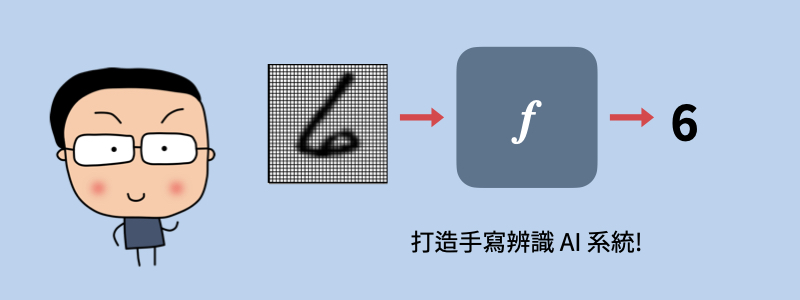

MNIST 是有一堆 0-9 的手寫數字圖庫。有 6 萬筆訓練資料, 1 萬筆測試資料。它是 "Modified" 版的 NIST 數據庫, 原來的版本有更多資料。這個 Modified 的版本是由 LeCun, Cortes, 及 Burges 等人做的。可以參考這個數據庫的[原始網頁](http://yann.lecun.com/exdb/mnist/)。

MNIST 可以說是 Deep Learning 最有名的範例, 它被 Deep Learning 大師 Hinton 稱為「機器學習的果蠅」。

### 2.1 由 Keras 讀入 MNIST

Keras 很貼心的幫我們準備好 MNIST 數據庫, 我們可以這樣讀進來 (第一次要花點時間)。

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

我們來看看訓練資料是不是 6 萬筆、測試資料是不是有 1 筆。

In [ ]:
print(f'訓練資料總筆數為 {len(x_train)} 筆資料')
print(f'測試資料總筆數為 {len(x_test)} 筆資料')

### 2.2 數據庫的內容

每筆輸入 (x) 就是一個手寫的 0-9 中一個數字的圖檔, 大小為 28x28。而輸出 (y) 當然就是「正確答案」。我們來看看編訓練資料的 x 輸入、輸出的部份分別長什麼樣子。

In [ ]:
def show_xy(n=0):
    ax = plt.gca()
    X = x_train[n]
    plt.xticks([], [])
    plt.yticks([], [])
    plt.imshow(X, cmap = 'Greys')
    print(f'本資料 y 給定的答案為: {y_train[n]}')

In [ ]:
interact_manual(show_xy, n=(0,59999));

In [ ]:
def show_data(n = 100):
    X = x_train[n]
    print(X)

In [ ]:
interact_manual(show_data, n=(0,59999));

### 2.3 輸入格式整理

我們現在要用標準神經網路學學手寫辨識。原來的每筆數據是個 28x28 的矩陣 (array), 但標準神經網路只吃「平平的」, 也就是每次要 28x28=784 長的向量。因此我們要用 `reshape` 調校一下。

##🧐我的筆記:

##可以看到有60000筆資料與一個28,28的矩陣(784維向量)

In [ ]:
x_train.shape

##🧐我的筆記:

#很重要

##原來數據是0~255為了不要讓數字太大我們要把它變成在1以內所以除255

In [ ]:
x_train = x_train.reshape(60000, 784)/255
x_test = x_test.reshape(10000, 784)/255

### 2.4 輸出格式整理
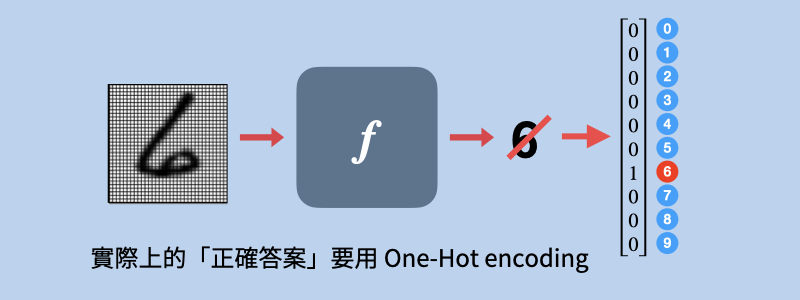

我們可能會想, 我們想學的函數是這樣的型式:

$$\hat{f} \colon \mathbb{R}^{784} \to \mathbb{R}$$

其實這樣不太好! 為什麼呢? 比如說我們的輸入 x 是一張 0 的圖, 因為我們訓練的神經網路總會有點誤差, 所以可能會得到:

$$\hat{f}(x) = 0.5$$

那這意思是有可能是 0, 也有可能是 1 嗎!!?? 可是 0 和 1 根本不像啊。換句話說分類的問題這樣做其實不合理!

於是我們會做 "1-hot enconding", 也就是

* 1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
* 5 -> [0, 0, 0, 0, 0, 1, 0, 0, 0]

等等。因為分類問題基本上都要做這件事, Keras 其實已幫我們準備好套件!

##🧐我的筆記:

##原本不是one-hot encoding，現在把它改成one-hot encoding，有十個類別，所以我們設10

(y_train裡面有10種類別)

In [ ]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

我們來看看剛剛某號數據的答案。

##🧐我的筆記:

##這邊可以看到當n=87時是9，所以在array中9的位置=1

In [ ]:
n = 87
y_train[n]

和我們想的一樣! 至此我們可以打造我們的神經網路了。

## 3. 打造第一個神經網路

我們決定了我們的函數是

$$\hat{f} \colon \mathbb{R}^{784} \to \mathbb{R}^{10}$$

這個樣子。而我們又說第一次要用標準神網路試試, 所以我們只需要再決定要幾個隱藏層、每層要幾個神經元, 用哪個激發函數就可以了。

### 3.1 決定神經網路架構、讀入相關套件

假如我們要用 ReLU 當激發函數, 要設計神經網路, 只差要指定多少個隱藏層、每層多少個神經元就好了!

設計完了基本上就是告訴 TensorFlow, 我們的想法就可以了!

### 3.2 建構我們的神經網路

和以前做迴歸或機器學習一樣, 我們就打開個「函數學習機」。標準一層一層傳遞的神經網路叫 `Sequential`, 於是我們打開一個空的神經網路。

##🧐我的筆記:

##先打造一個空白的函數學習機

In [ ]:
model = Sequential()

我們每次用 `add` 去加一層, 從第一個隱藏層開始。而第一個隱藏層因為 TensorFlow 當然猜不到輸入有 784 個 features, 所以我們要告訴它。

##🧐我的筆記:

##用add方法把隱藏曾加進去，我們使用Dense層(全連接神經網路),且第一次要先告訴model它的輸入層多大(input_dim=784),在宣告使用的激活函數(activation='relu')，

##這邊我使用LeakyReLU當我的激活函數，它是ReLU 的保險版，在負半軸保留一點斜率（例如 0.01），可減少 dead neurons 問題。

##激活函數的選擇有請GPT幫忙

In [ ]:
model.add(Dense(N1, input_dim=784, activation=tf.nn.leaky_relu))

第二層開始就不用再說明輸入神經元個數 (因為就是前一層神經元數)。

In [ ]:
model.add(Dense(N2, activation=tf.nn.leaky_relu))

In [ ]:
model.add(Dense(N3, activation=tf.nn.leaky_relu))

In [ ]:
model.add(Dense(N4, activation=tf.nn.leaky_relu))

In [ ]:
model.add(Dense(N5, activation=tf.nn.leaky_relu))

輸出有 10 個數字, 所以輸出層的神經元是 10 個! 而如果我們的網路輸出是

$$(y_1, y_2, \ldots, y_{10})$$

我們還希望

$$\sum_{i=1}^{10} y_i = 1$$

這可能嗎, 結果是很容易, 就用 `softmax` 當激發函數就可以!!

##🧐我的筆記:

##輸出層，告訴她輸出有幾個類別，並且activation改成softmax(因為我們想要讓數值在0~1之間)

In [ ]:
model.add(Dense(10, activation='softmax'))

至此我們的第一個神經網路就建好了!

### 3.3 組裝

和之前比較不一樣的是我們還要做 `compile` 才正式把我們的神經網路建好。你可以發現我們還需要做幾件事:

* 決定使用的 loss function, 一般是 `mse`
* 決定 optimizer, 我們用標準的 SGD
* 設 learning rate

為了一邊訓練一邊看到結果, 我們加設

    metrics=['accuracy']
    
本行基本上和我們的神經網路功能沒有什麼關係。

##🧐我的筆記:

##loss使用均方差(mse)，單它對於分類方法不是最好的loss,優化器使用SGD，learning_rate是學習的步伐，最後設定她要一直跟我們說它的正確率。

##這邊我使用:多類單選SparseCategoricalCrossentropy

##LOSS的選擇有請GPT幫忙

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.087), metrics=['accuracy'])

## 4. 檢視我們的神經網路

我們可以檢視我們神經網路的架構, 可以確認一下是不是和我們想像的一樣。

### 4.1 看 model 的 summary

In [ ]:
model.summary()

很快算算參數數目和我們想像是否是一樣的!

## 5. 訓練你的第一個神經網路

恭喜! 我們完成了第一個神經網路。現在要訓練的時候, 你會發現不是像以前沒頭沒腦把訓練資料送進去就好。這裡我們還有兩件事要決定:

* 一次要訓練幾筆資料 (`batch_size`), 我們就 100 筆調一次參數好了
* 這 6 萬筆資料一共要訓練幾次 (`epochs`), 我們訓練個 10 次試試

於是最精彩的就來了。你要有等待的心理準備...

##🧐我的筆記:

##FIT:開始訓練(data,答案,一次100提檢討一次答案,10
##更改loss後我可以用更少的epoch達到更高的準確度，但我想要有更精確的結果所以把epoch改成30

In [ ]:
model.fit(x_train, y_train, batch_size=100, epochs=30)

## 6. 試用我們的結果

我們來用比較炫的方式來看看可愛的神經網路學習成果。對指令有問題可以參考《少年Py的大冒險：成為Python數據分析達人的第一門課》。

In [ ]:
loss, acc = model.evaluate(x_test, y_test)

In [ ]:
print(f"測試資料正確率 {acc*100:.2f}%")

我們 "predict" 放的是我們神經網路的學習結果。做完之後用 argmax 找到數值最大的那一項。

In [ ]:
predict = np.argmax(model.predict(x_test), axis=-1)

In [ ]:
predict

不要忘了我們的 `x_test` 每筆資料已經換成 784 維的向量, 我們要整型回 28x28 的矩陣才能當成圖形顯示出來!

In [ ]:
def test(測試編號):
    plt.imshow(x_test[測試編號].reshape(28,28), cmap='Greys')
    print('神經網路判斷為:', predict[測試編號])

In [ ]:
interact_manual(test, 測試編號=(0, 9999));

到底測試資料總的狀況如何呢? 我們可以給我們神經網路「總評量」。

In [ ]:
score = model.evaluate(x_test, y_test)

In [ ]:
print('loss:', score[0])
print('正確率', score[1])

### 7. 用 Gradio 來展示

In [ ]:
def resize_image(inp):
    # 圖在 inp["layers"][0]
    image = np.array(inp["layers"][0], dtype=np.float32)
    image = image.astype(np.uint8)

    # 轉成 PIL 格式
    image_pil = Image.fromarray(image)

    # Alpha 通道設為白色, 再把圖從 RGBA 轉成 RGB
    background = Image.new("RGB", image_pil.size, (255, 255, 255))
    background.paste(image_pil, mask=image_pil.split()[3]) # 把圖片粘貼到白色背景上，使用透明通道作為遮罩
    image_pil = background

    # 轉換為灰階圖像
    image_gray = image_pil.convert("L")

    # 將灰階圖像縮放到 28x28, 轉回 numpy array
    img_array = np.array(image_gray.resize((28, 28), resample=Image.LANCZOS))

    # 配合 MNIST 數據集
    img_array = 255 - img_array

    # 拉平並縮放
    img_array = img_array.reshape(1, 784) / 255.0

    return img_array

In [ ]:
def recognize_digit(inp):
    img_array = resize_image(inp)
    prediction = model.predict(img_array).flatten()
    labels = list('0123456789')
    return {labels[i]: float(prediction[i]) for i in range(10)}

In [ ]:
iface = gr.Interface(
    fn=recognize_digit,
    inputs=gr.Sketchpad(),
    outputs=gr.Label(num_top_classes=3),
    title="MNIST 手寫辨識",
    description="請在畫板上繪製數字"
)

iface.launch(share=True, debug=True)

##🧐我的筆記:

##我把我的模型匯出，我使用keras格式

##因為:保留模型結構、權重、Optimizer 狀態、訓練配置；跨平台、易讀回。

In [ ]:
# 儲存
model.save("week2_homework_model.keras")

